# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite

import thinkbayes2
import thinkplot

import numpy as np
from scipy.special import gamma

import pymc3 as pm

/home/downey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## The World Cup Problem, Part One

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Let's assume that Germany has some hypothetical goal-scoring rate, λ, in goals per game.

To represent the prior distribution of λ, I'll use a Gamma distribution with mean 1.3, which is the average number of goals per team per game in World Cup play.

Here's what the prior looks like.

1.3265543887538014

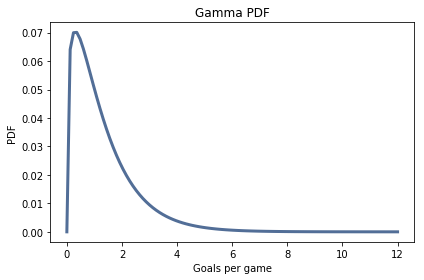

In [2]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 12, 101)
pmf_gamma = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf_gamma)
thinkplot.decorate(title='Gamma PDF',
                   xlabel='Goals per game',
                   ylabel='PDF')
pmf_gamma.Mean()

In [3]:
class Soccer(Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: scoring rate in goals per game
        data: interarrival time in minutes
        """
        x = data / 90
        lam = hypo
        like = lam * np.exp(-lam * x)
        return like

Now we can create a `Soccer` object and initialize it with the prior Pmf:

1.3265543887538014

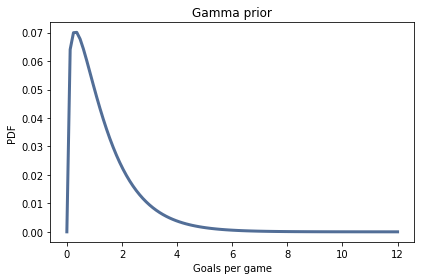

In [4]:
prior = Soccer(pmf_gamma)
thinkplot.Pdf(prior)
thinkplot.decorate(title='Gamma prior',
                   xlabel='Goals per game',
                   ylabel='PDF')
prior.Mean()

Here's the update after the first goal at 11 minutes.

2.049879172050407

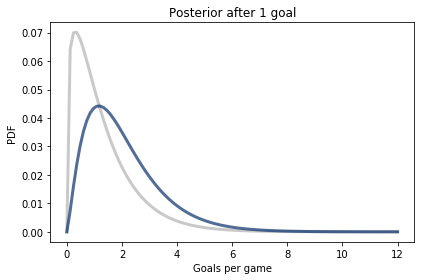

In [5]:
posterior1 = prior.Copy()
posterior1.Update(11)

thinkplot.Pdf(prior, color='0.7')
thinkplot.Pdf(posterior1)
thinkplot.decorate(title='Posterior after 1 goal',
                   xlabel='Goals per game',
                   ylabel='PDF')
posterior1.Mean()

Here's the update after the second goal at 23 minutes (the time between first and second goals is 12 minutes).


2.62769089715974

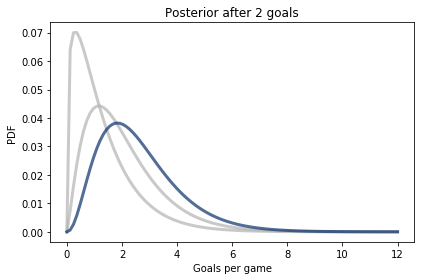

In [6]:
posterior2 = posterior1.Copy()
posterior2.Update(12)

thinkplot.Pdf(prior, color='0.7')
thinkplot.Pdf(posterior1, color='0.7')
thinkplot.Pdf(posterior2)

thinkplot.decorate(title='Posterior after 2 goals',
                   xlabel='Goals per game',
                   ylabel='PDF')
posterior2.Mean()

In [7]:
from thinkbayes2 import MakePoissonPmf

We can compute the mixture of these distributions by making a Meta-Pmf that maps from each Poisson Pmf to its probability.

In [8]:
rem_time = 90 - 23

metapmf = Pmf()
for lam, prob in posterior2.Items():
    lt = lam * rem_time / 90
    pred = MakePoissonPmf(lt, 15)
    metapmf[pred] = prob

`MakeMixture` takes a Meta-Pmf (a Pmf that contains Pmfs) and returns a single Pmf that represents the weighted mixture of distributions:

In [9]:
def MakeMixture(metapmf, label='mix'):
    """Make a mixture distribution.

    Args:
      metapmf: Pmf that maps from Pmfs to probs.
      label: string label for the new Pmf.

    Returns: Pmf object.
    """
    mix = Pmf(label=label)
    for pmf, p1 in metapmf.Items():
        for x, p2 in pmf.Items():
            mix[x] += p1 * p2
    return mix

Here's the result for the World Cup problem.

In [10]:
mix = MakeMixture(metapmf)
mix.Print()

0 0.21517463028972725
1 0.264302249774796
2 0.21151498217528292
3 0.1390906939615146
4 0.08154152382879802
5 0.044312142685748304
6 0.02281453694723827
7 0.011279294601411206
8 0.005401795735609347
9 0.0025207018987942345
10 0.0011505436156713563
11 0.0005148715941114398
12 0.00022615293328951343
13 9.75179518113058e-05
14 4.1256397217875616e-05
15 1.710560897772643e-05


And here's what the mixture looks like.

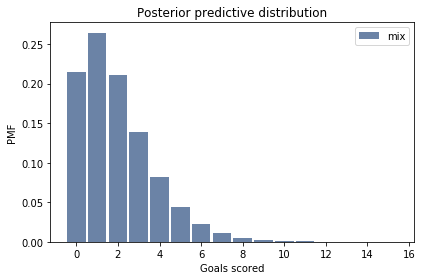

In [11]:
thinkplot.Hist(mix)
thinkplot.decorate(title='Posterior predictive distribution',
                   xlabel='Goals scored', 
                   ylabel='PMF')

**Exercise:** Compute the predictive mean and the probability of scoring 5 or more additional goals.

In [12]:
# Solution

mix.Mean(), mix.ProbGreater(4)

(1.9560588375818466, 0.08837591996988058)

## MCMC

Building the MCMC model incrementally, start with just the prior distribution for `lam`.

In [13]:
cdf_gamma = pmf_gamma.MakeCdf();

In [14]:
mean_rate = 1.3

with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=mean_rate, beta=1)
    trace = pm.sample_prior_predictive(1000)

1.3221907725128716


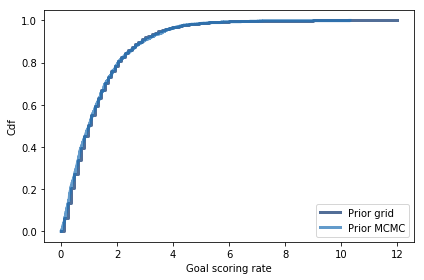

In [15]:
lam_sample = trace['lam']
print(lam_sample.mean())

cdf_lam = Cdf(lam_sample)
thinkplot.Cdf(cdf_gamma, label='Prior grid')
thinkplot.Cdf(cdf_lam, label='Prior MCMC')
thinkplot.decorate(xlabel='Goal scoring rate',
                   ylabel='Cdf')

Let's look at the prior predictive distribution for the time between goals (in games).

In [16]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=mean_rate, beta=1)
    gap = pm.Exponential('gap', lam)
    trace = pm.sample_prior_predictive(1000)

2.4291415392748124


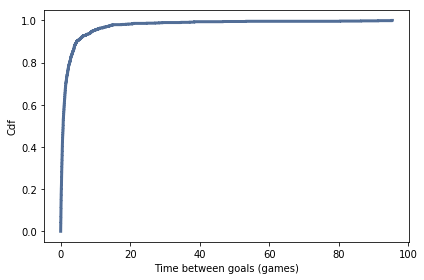

In [17]:
gap_sample = trace['gap']
print(gap_sample.mean())
cdf_lam = Cdf(gap_sample)

thinkplot.Cdf(cdf_lam)
thinkplot.decorate(xlabel='Time between goals (games)',
                   ylabel='Cdf')

Now we're ready for the inverse problem, estimating `lam` based on the first observed gap.

In [18]:
first_gap = 11/90

with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=mean_rate, beta=1)
    gap = pm.Exponential('gap', lam, observed=first_gap)
    trace = pm.sample(1000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:03<00:00, 4777.09draws/s]


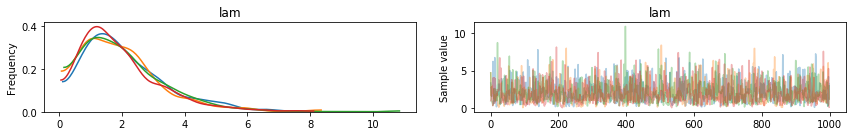

In [19]:
pm.traceplot(trace);

2.0491846478187727
2.049879172050407


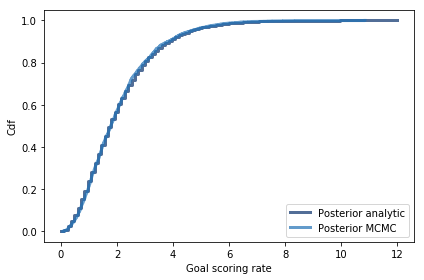

In [20]:
lam_sample = trace['lam']
print(lam_sample.mean())
print(posterior1.Mean())
cdf_lam = Cdf(lam_sample)

thinkplot.Cdf(posterior1.MakeCdf(), label='Posterior analytic')
thinkplot.Cdf(cdf_lam, label='Posterior MCMC')
thinkplot.decorate(xlabel='Goal scoring rate',
                   ylabel='Cdf')

And here's the inverse problem with both observed gaps.

In [21]:
second_gap = 12/90

with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=mean_rate, beta=1)
    gap = pm.Exponential('gap', lam, observed=[first_gap, second_gap])
    trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4617.28draws/s]


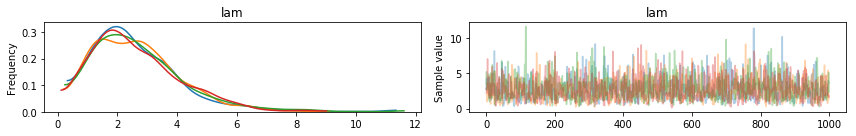

In [22]:
pm.traceplot(trace);

2.6691664097102783
2.62769089715974


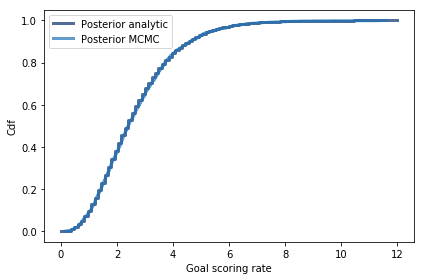

In [23]:
lam_sample = trace['lam']
print(lam_sample.mean())
print(posterior2.Mean())
cdf_lam = Cdf(lam_sample)

thinkplot.Cdf(posterior2.MakeCdf(), label='Posterior analytic')
thinkplot.Cdf(cdf_lam, label='Posterior MCMC')
thinkplot.decorate(xlabel='Goal scoring rate',
                   ylabel='Cdf')

And we can generate a predictive distribution for the time until the next goal (in games).

In [24]:
with model:
    post_pred = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 6646.85it/s]


0.5260392128212112


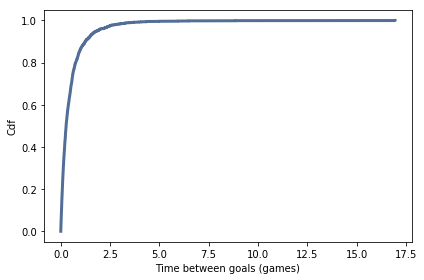

In [25]:
gap_sample = post_pred['gap'].flatten()
print(gap_sample.mean())

cdf_gap = Cdf(gap_sample)
thinkplot.Cdf(cdf_gap)
thinkplot.decorate(xlabel='Time between goals (games)',
                   ylabel='Cdf')

**Exercise:** Use PyMC to write a solution to the second World Cup problem:

>In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. How much evidence does this victory provide that Germany had the better team? What is the probability that Germany would win a rematch?

In [26]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=mean_rate, beta=1)
    goals = pm.Poisson('goals', lam, observed=1)
    trace = pm.sample(1000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:03<00:00, 4739.71draws/s]
The acceptance probability does not match the target. It is 0.6960880071834263, but should be close to 0.8. Try to increase the number of tuning steps.


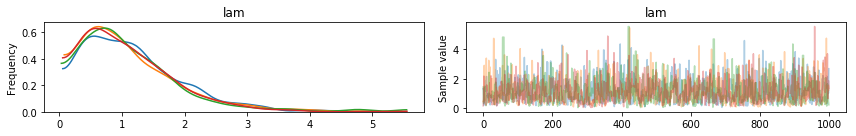

In [27]:
pm.traceplot(trace);

1.141838409859012


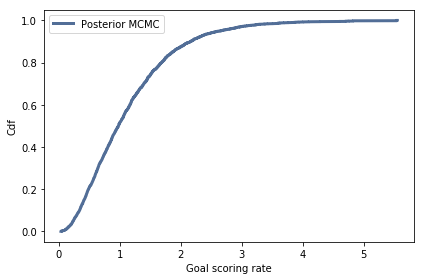

In [28]:
lam_sample = trace['lam']
print(lam_sample.mean())
cdf_lam = Cdf(lam_sample)

thinkplot.Cdf(cdf_lam, label='Posterior MCMC')
thinkplot.decorate(xlabel='Goal scoring rate',
                   ylabel='Cdf')

And we can generate a predictive distribution for the time until the next goal (in games).

In [29]:
with model:
    post_pred = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 3023.21it/s]


1.078


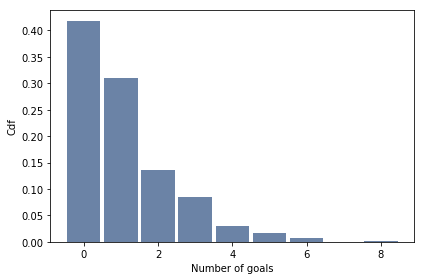

In [30]:
goal_sample = post_pred['goals'].flatten()
print(goal_sample.mean())

pmf_goals = Pmf(goal_sample)
thinkplot.Hist(pmf_goals)
thinkplot.decorate(xlabel='Number of goals',
                   ylabel='Cdf')

In [31]:
from scipy.stats import poisson

class Soccer2(thinkbayes2.Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: goal rate in goals per game
        data: goals scored in a game
        """
        return poisson.pmf(data, hypo) 

1.310359949002256

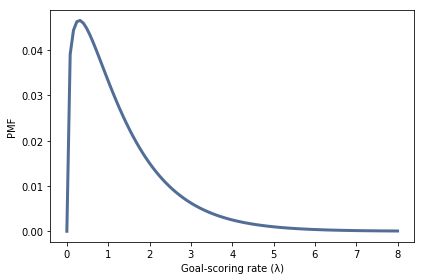

In [32]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 8, 101)
pmf = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf)
thinkplot.decorate(xlabel='Goal-scoring rate (λ)',
                   ylabel='PMF')
pmf.Mean()

In [33]:
germany = Soccer2(pmf);

In [34]:
germany.Update(1)

0.2672600332392517

In [35]:
def PredictiveDist(suite, duration=1, label='pred'):
    """Computes the distribution of goals scored in a game.

    returns: new Pmf (mixture of Poissons)
    """
    metapmf = thinkbayes2.Pmf()
    for lam, prob in suite.Items():
        pred = thinkbayes2.MakePoissonPmf(lam * duration, 10)
        metapmf[pred] = prob

    mix = thinkbayes2.MakeMixture(metapmf, label=label)
    return mix

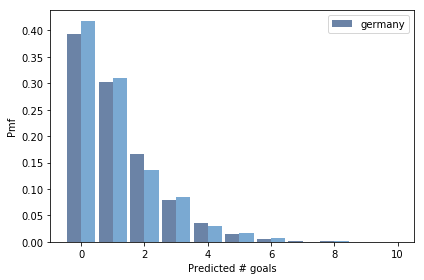

In [36]:
germany_pred = PredictiveDist(germany, label='germany')

thinkplot.Hist(germany_pred, width=0.45, align='right')
thinkplot.Hist(pmf_goals, width=0.45, align='left')
thinkplot.decorate(xlabel='Predicted # goals',
                   ylabel='Pmf')

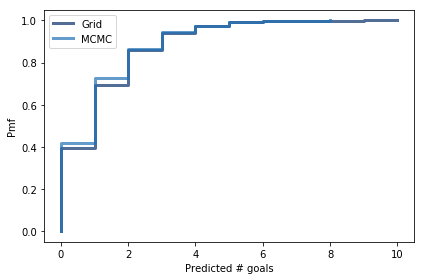

In [37]:
thinkplot.Cdf(germany_pred.MakeCdf(), label='Grid')
thinkplot.Cdf(Cdf(goal_sample), label='MCMC')
thinkplot.decorate(xlabel='Predicted # goals',
                   ylabel='Pmf')